# ＧＸゲームアニメ日株ETF 日足

In [1]:
import sys
import os
import re

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

try:
    __file__
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
except NameError:
    from pathlib import Path
    Path().resolve()
    sys.path.append(os.path.join(Path().resolve(), '..'))

from funcs.technical import psar

In [2]:
pattern = re.compile(r'(.+)\.T')

symbol = '2640.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='6mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2024-09-05 00:00:00+09:00,3110.0,3160.0,3100.0,3130.0,3184,0.0,0.0,0.0
2024-09-06 00:00:00+09:00,3140.0,3195.0,3125.0,3130.0,352,0.0,0.0,0.0
2024-09-09 00:00:00+09:00,3060.0,3140.0,3060.0,3130.0,534,0.0,0.0,0.0
2024-09-10 00:00:00+09:00,3170.0,3175.0,3140.0,3165.0,198,0.0,0.0,0.0
2024-09-11 00:00:00+09:00,3160.0,3165.0,3080.0,3110.0,2427,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2025-02-27 00:00:00+09:00,4000.0,4040.0,3965.0,4005.0,4090,0.0,0.0,0.0
2025-02-28 00:00:00+09:00,3950.0,3980.0,3910.0,3945.0,5827,0.0,0.0,0.0
2025-03-03 00:00:00+09:00,4015.0,4015.0,3910.0,3970.0,5414,0.0,0.0,0.0


## 日足チャートとパラボリック SAR

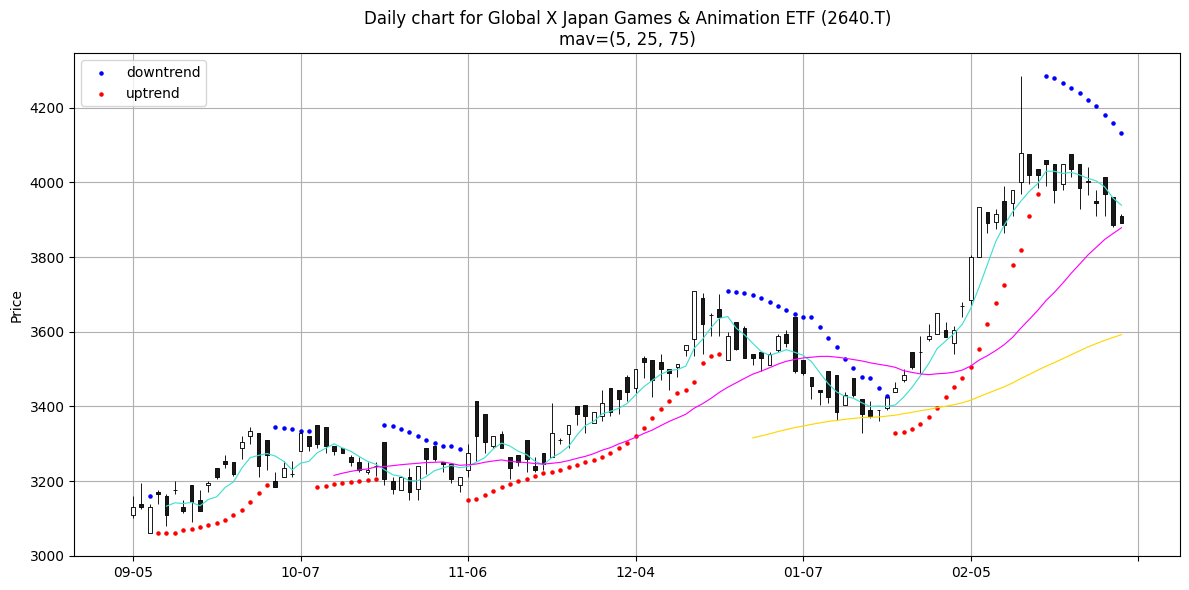

In [3]:
dict_psar = psar(df)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=5,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=5,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=False,
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)

try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax.grid()
ax.legend(loc='upper left')

plt.tight_layout()

m = pattern.match(symbol)
if m:
    plt.savefig('daily_chart_%s.png' % m.group(1))
else:
    plt.savefig('daily_chart_%s.png' % symbol)

plt.show()

In [4]:
df.tail(2)['Close']

Date
2025-03-04 00:00:00+09:00    3885.0
2025-03-05 00:00:00+09:00    3890.0
Name: Close, dtype: float64

In [5]:
df.tail(2)['Close'].diff()

Date
2025-03-04 00:00:00+09:00    NaN
2025-03-05 00:00:00+09:00    5.0
Name: Close, dtype: float64

In [6]:
df['Close'].rolling(5).mean().tail(2)

Date
2025-03-04 00:00:00+09:00    3958.0
2025-03-05 00:00:00+09:00    3939.0
Name: Close, dtype: float64

In [7]:
df['Close'].rolling(25).mean().tail(2)

Date
2025-03-04 00:00:00+09:00    3863.2
2025-03-05 00:00:00+09:00    3878.6
Name: Close, dtype: float64

In [8]:
df['Close'].rolling(75).mean().tail(2)

Date
2025-03-04 00:00:00+09:00    3584.8
2025-03-05 00:00:00+09:00    3592.4
Name: Close, dtype: float64